In [1]:
#inmport libraries
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
print('Libraries imported')

Libraries imported


<b>Scraping Neighborhood list from Wikipedia

In [2]:
nyc_wiki_url = 'https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City'
nyc_wiki = requests.get(nyc_wiki_url).text
nyc_soup = BeautifulSoup(nyc_wiki, 'lxml')
nyc_neigh_table = nyc_soup.table.tbody.find_all('tr')
del nyc_neigh_table[0]
del nyc_neigh_table[-1]

<b>Create Dataframe

In [3]:
nyc_neighborhood = []
for row in nyc_neigh_table:
    borough = row.find_all('td')[0].text.replace(u'\xa0', ' ').split(' ')
    borough.remove('CB')
    borough.pop()
    borough = ' '.join(borough)
    neighborhoods = row.find_all('td')[-1].text.strip().split(', ')
    for i in range(len(neighborhoods)):
        nyc_neighborhood.append([borough, neighborhoods[i]])
df_nyc_neighborhood = pd.DataFrame(nyc_neighborhood, columns = ['Borough', 'Neighborhood'])
df_nyc_neighborhood.drop_duplicates(inplace = True)
df_nyc_neighborhood.head()

,Borough,Neighborhood
0,Bronx,Melrose
1,Bronx,Mott Haven
2,Bronx,Port Morris
3,Bronx,Hunts Point
4,Bronx,Longwood


<b>Since scraping rental price from StreetEasy is prevented by the website, rental data of RentCafe is used instead. RentCafe provides the average rental prices of neighborhoods in Manhattan, Brooklyn, Bronx and Queens, thus, only those neighborhoods in the four mentioned boroughs with their rental prices provided will be investigated in the following session.

In [4]:
borough_list = ['manhattan','brooklyn', 'bronx', 'queens']
rental_price = []
for borough in borough_list:
    rentcafe_url = 'https://www.rentcafe.com/average-rent-market-trends/us/ny/' + borough + '/'
    rentcafe = requests.get(rentcafe_url).text
    rentcafe_soup = BeautifulSoup(rentcafe, 'lxml')
    rentcafe_table = rentcafe_soup.find('table', id = "MarketTrendsAverageRentTable").tbody.find_all('tr')
    del rentcafe_table[0]
    for row in rentcafe_table:
        neighborhood = row.th.text
        price = row.td.text.replace('$', '').replace(',', '')
        rental_price.append([borough.capitalize(), neighborhood, price])
df_rental_price = pd.DataFrame(rental_price, columns = ['Borough', 'Neighborhood', 'Average rental price / $'])

In [5]:
print('The average rental prices of ' + str(df_rental_price.shape[0]) + ' neighborhoods are found.')
df_rental_price.head()

The average rental prices of 133 neighborhoods are found.


,Borough,Neighborhood,Average rental price / $
0,Manhattan,Marble Hill,1694
1,Manhattan,Inwood,2225
2,Manhattan,Washington Heights,2243
3,Manhattan,Randalls and Wards Islands,2336
4,Manhattan,East Harlem,3334


<b>Get the geometrical data of neighborhoods in New York City

In [6]:
import json
from pandas.io.json import json_normalize
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
nyc_data = newyork_data['features']
df_nyc_data = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in nyc_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_lat = data['geometry']['coordinates'][1]
    neighborhood_lon = data['geometry']['coordinates'][0]
    
    df_nyc_data = df_nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
df_nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
df_rental_price['Latitude'] = 0
df_rental_price['Longitude'] = 0
df_rental_price.head()

,Borough,Neighborhood,Average rental price / $,Latitude,Longitude
0,Manhattan,Marble Hill,1694,0,0
1,Manhattan,Inwood,2225,0,0
2,Manhattan,Washington Heights,2243,0,0
3,Manhattan,Randalls and Wards Islands,2336,0,0
4,Manhattan,East Harlem,3334,0,0


In [8]:
for i in range(df_rental_price.shape[0]):
    match = df_nyc_data.loc[df_nyc_data['Neighborhood'] == df_rental_price.iloc[i, 1]]
    match1 = match.loc[match['Borough'] == df_rental_price.iloc[i, 0]]
    if not(match1.empty):
        df_rental_price.iloc[i, 3] = match1['Latitude'].values
        df_rental_price.iloc[i, 4] = match1['Longitude'].values
df_rental_price.head()

,Borough,Neighborhood,Average rental price / $,Latitude,Longitude
0,Manhattan,Marble Hill,1694,40.876551,-73.910660
1,Manhattan,Inwood,2225,40.867684,-73.921210
2,Manhattan,Washington Heights,2243,40.851903,-73.936900
3,Manhattan,Randalls and Wards Islands,2336,0.000000,0.000000
4,Manhattan,East Harlem,3334,40.792249,-73.944182


In [9]:
df_rental_summary = df_rental_price[df_rental_price.Latitude != 0]
df_rental_summary.reset_index(drop = True, inplace = True)
df_rental_summary = df_rental_summary.astype({'Average rental price / $': int})
df_rental_summary.to_csv('Rental_Price_in_NYC.csv')

<b>Take a look at the rental price in different boroughs

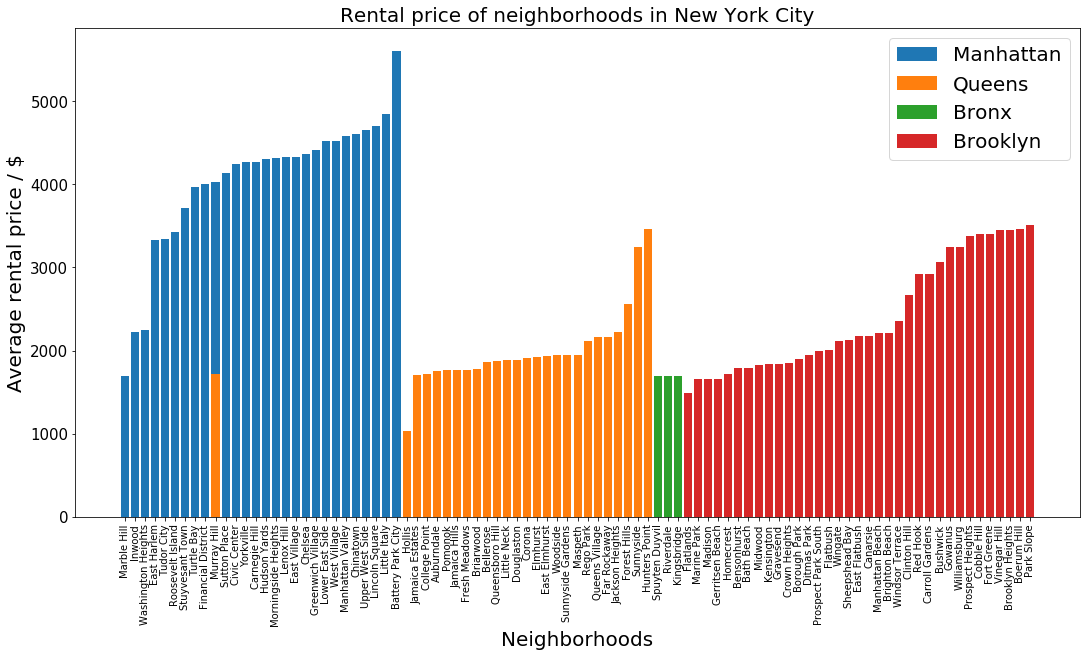

In [12]:
df_manhattan_price = df_rental_summary[df_rental_summary['Borough'] == 'Manhattan']
df_queens_price = df_rental_summary[df_rental_summary['Borough'] == 'Queens']
df_bronx_price = df_rental_summary[df_rental_summary['Borough'] == 'Bronx']
df_brooklyn_price = df_rental_summary[df_rental_summary['Borough'] == 'Brooklyn']
plt.figure(figsize = (18,9))
plt.bar(df_manhattan_price['Neighborhood'], df_manhattan_price['Average rental price / $'], label = 'Manhattan')
plt.bar(df_queens_price['Neighborhood'], df_queens_price['Average rental price / $'], label = 'Queens')
plt.bar(df_bronx_price['Neighborhood'], df_bronx_price['Average rental price / $'], label = 'Bronx')
plt.bar(df_brooklyn_price['Neighborhood'], df_brooklyn_price['Average rental price / $'], label = 'Brooklyn')
plt.xticks(rotation = 90)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)
plt.xlabel('Neighborhoods', fontsize = 20)
plt.ylabel('Average rental price / $', fontsize = 20)
plt.title('Rental price of neighborhoods in New York City', fontsize = 20)
plt.show()

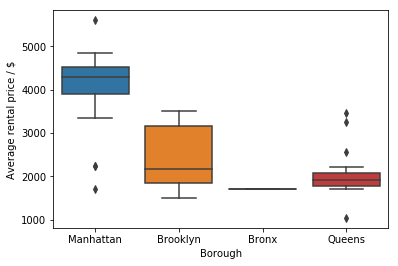

In [13]:
sns.boxplot(x="Borough", y="Average rental price / $", data=df_rental_summary)

<b>The above graphs show the differences of the average rental prices in respect to the boroughs. Manhattan is the most expensive to live, while Bronx is the cheapest borough. 

<b>Using FourSquare API to query venues in given neighborhood

In [10]:
#Foursquare query
CLIENT_ID = 'TLCR53MOFEEQI5VHWCREEZYFAUCK4IJDX00GDLZMFGROLB2S' 
CLIENT_SECRET = '54YKMSMH05QBJI0JFB30QW3KE50OHZJXQ3WQTLVMERYV0ARA' 
VERSION = '20190329'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TLCR53MOFEEQI5VHWCREEZYFAUCK4IJDX00GDLZMFGROLB2S
CLIENT_SECRET:54YKMSMH05QBJI0JFB30QW3KE50OHZJXQ3WQTLVMERYV0ARA


In [11]:
def getNearbyVenues(borough, neighborhood_names, latitudes, longitudes, radius = 500, LIMIT = 100):
    
    venues = []
    i = 0
    for bor, neigh, lat, lng in zip(borough, neighborhood_names, latitudes, longitudes):
        i += 1
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},\
        {}&v={}&query={}&radius={}&limit={}'.format\
        (CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, neigh, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(str(i) + ', ' + bor + ' ' + neigh + ' ' + str(len(results)) + ' venues found.')
        # return only relevant information for each nearby venue
        j = 0
        for item in results:                
            if item['venue']['name'] and item['venue']['location']['lat']\
            and item['venue']['location']['lng'] and item['venue']['categories']: 
                venues.append([
                bor,
                neigh, 
                lat, 
                lng,                     
                item['venue']['name'], 
                item['venue']['location']['lat'], 
                item['venue']['location']['lng'],  
                item['venue']['categories'][0]['name']])
                j += 1 
        print(str(j) + ' venues imported')
    df_venues = pd.DataFrame(venues, columns = ['Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                                                'Venue','Venue Latitude', 'Venue Longitude', 'Venue Category'])
    return(df_venues)

In [12]:
df_venues = getNearbyVenues(df_rental_summary['Borough'], 
                df_rental_summary['Neighborhood'], 
                df_rental_summary['Latitude'], 
                df_rental_summary['Longitude'])

1, Manhattan Marble Hill 7 venues found.
7 venues imported
2, Manhattan Inwood 18 venues found.
18 venues imported
3, Manhattan Washington Heights 16 venues found.
16 venues imported
4, Manhattan East Harlem 19 venues found.
19 venues imported
5, Manhattan Tudor City 9 venues found.
9 venues imported
6, Manhattan Roosevelt Island 11 venues found.
11 venues imported
7, Manhattan Stuyvesant Town 9 venues found.
9 venues imported
8, Manhattan Turtle Bay 4 venues found.
4 venues imported
9, Manhattan Financial District 100 venues found.
100 venues imported
10, Manhattan Murray Hill 47 venues found.
47 venues imported
11, Manhattan Sutton Place 18 venues found.
18 venues imported
12, Manhattan Civic Center 2 venues found.
2 venues imported
13, Manhattan Yorkville 10 venues found.
10 venues imported
14, Manhattan Carnegie Hill 7 venues found.
7 venues imported
15, Manhattan Hudson Yards 5 venues found.
5 venues imported
16, Manhattan Morningside Heights 4 venues found.
4 venues imported
17, 

In [13]:
df_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Marble Hill,40.876551,-73.91066,Metro North - Marble Hill Train Station,40.874698,-73.912052,Train Station
1,Manhattan,Marble Hill,40.876551,-73.91066,Marble Hill Youthmarket,40.874519,-73.910394,Farmers Market
2,Manhattan,Marble Hill,40.876551,-73.91066,marble hill pharmacy,40.875050,-73.909195,Pharmacy
3,Manhattan,Marble Hill,40.876551,-73.91066,MTA Subway - 225th St/Marble Hill (1),40.874486,-73.909589,Metro Station
4,Manhattan,Marble Hill,40.876551,-73.91066,Marble Hill Playground,40.877765,-73.907994,Playground


In [17]:
df_venues.to_csv('Venue_found_in_NYC.csv')

In [14]:
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
df_onehot.shape

(1519, 251)

In [15]:
df_venue_counts = df_venues.groupby(['Borough', 'Neighborhood']).size().reset_index(name='counts')
df_venue_counts = df_venue_counts.merge(df_rental_summary[['Borough', 'Neighborhood', 'Average rental price / $']], on = ['Borough', 'Neighborhood'])


<b>Examine whether the rental prices correlate to the number of venues

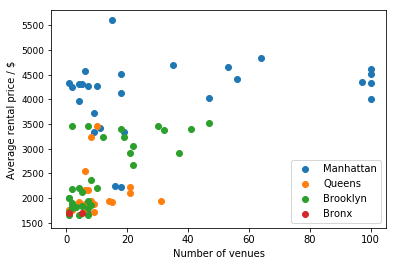

In [16]:
df_manhattan_counts = df_venue_counts[df_venue_counts['Borough'] == 'Manhattan']
df_queens_counts = df_venue_counts[df_venue_counts['Borough'] == 'Queens']
df_brooklyn_counts = df_venue_counts[df_venue_counts['Borough'] == 'Brooklyn']
df_bronx_counts = df_venue_counts[df_venue_counts['Borough'] == 'Bronx']
plt.scatter(df_manhattan_counts['counts'], df_manhattan_counts['Average rental price / $'], label = 'Manhattan')
plt.scatter(df_queens_counts['counts'], df_queens_counts['Average rental price / $'], label = 'Queens')
plt.scatter(df_brooklyn_counts['counts'], df_brooklyn_counts['Average rental price / $'], label = 'Brooklyn')
plt.scatter(df_bronx_counts['counts'], df_bronx_counts['Average rental price / $'], label = 'Bronx')
plt.yticks(fontsize = 9)
plt.xlabel('Number of venues')
plt.ylabel('Average rental price / $')
plt.legend()
plt.show()

<b>Recalling the ranking of rental expensiveness represented by the boxplot of average rental prices in the four boroughs, this scatter plot roughly shows the sense that people living in expensive boroughs actively use FourSquare.

In [30]:
df_venue_counts['Average rental price / $'].to_numpy()

array([1694, 1694, 1795, 1795, 3462, 1898, 2214, 3456, 3065, 2178, 2916,
       2671, 3401, 1853, 1944, 2009, 3403, 1659, 3247, 1840, 1717, 1839,
       1659, 2214, 1659, 1825, 3513, 3373, 1997, 2916, 2131, 3456, 3247,
       2361, 5603, 4271, 4359, 4609, 4241, 3334, 4334, 4005, 4415, 4302,
       2225, 4332, 4706, 4845, 4516, 4578, 1694, 4314, 4022, 3427, 3720,
       4135, 3338, 3973, 4654, 2243, 4524, 4271, 1750, 1861, 1773, 1719,
       1917, 1891, 1922, 2162, 2558, 1766, 3466, 2222, 1766, 1891, 1950,
       1719, 2160, 2110, 3248, 1950, 1950])

The Pearson Correlation Coefficient is [0.53951613]  with a P-value of P = [1.41794158e-07]
R-sqaured is  0.29107765218140885


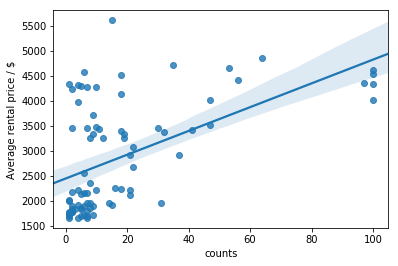

In [33]:
sns.regplot(x = 'counts', y = 'Average rental price / $', data = df_venue_counts)
pearson_coef, p_value = stats.pearsonr(df_venue_counts[['counts']], df_venue_counts[['Average rental price / $']])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
r_value = stats.linregress(df_venue_counts['counts'].to_numpy(), df_venue_counts['Average rental price / $'].to_numpy()).rvalue
print('R-sqaured is ', r_value**2)

<b>Since the p-value is $<<$ 0.001, the correlation between the number of venues and rental price is statistically significant. Although the linear relationship isn't extremely strong (~0.5395), meaning that no clear correlation function between these two quantities can be found, it shows the number of venues positively correlates to the rental price.

<b>Check venue categories

In [36]:
df_venues.groupby('Venue Category').size()

Venue Category
Accessories Store                            1
American Restaurant                         36
Arepa Restaurant                             1
Argentinian Restaurant                       1
Art Gallery                                  9
Arts & Crafts Store                          2
Asian Restaurant                             4
Athletics & Sports                           2
Australian Restaurant                        1
BBQ Joint                                    7
Bagel Shop                                  25
Bakery                                      42
Bank                                         6
Bar                                         63
Baseball Field                               2
Basketball Court                             2
Beach                                        2
Beer Bar                                     4
Beer Garden                                  1
Beer Store                                   1
Big Box Store                                

<b>Most of the recorded venues are living relevant, rather than working relevant. However, the venue categories are too precise, making it difficult to analyse the relationship between the rental prices and the existence of venues. Thus, the venues will be further classified into restaurant, entertainment and miscellaneous convenience according keywords.

<b>Prepare DataFrame for the re-categorising

In [37]:
df_rental_summary[['Restaurant', 'Entertainment', 'Miscellaneous Convenience']] = pd.DataFrame([[0, 0, 0]], index = df_rental_summary.index)
df_rental_summary.head()

,Borough,Neighborhood,Average rental price / $,Latitude,Longitude,Restaurant,Entertainment,Miscellaneous Convenience
0,Manhattan,Marble Hill,1694,40.876551,-73.910660,0,0,0
1,Manhattan,Inwood,2225,40.867684,-73.921210,0,0,0
2,Manhattan,Washington Heights,2243,40.851903,-73.936900,0,0,0
3,Manhattan,East Harlem,3334,40.792249,-73.944182,0,0,0
4,Manhattan,Tudor City,3338,40.746917,-73.971219,0,0,0


<b>Classify the venues into redifined categories

In [38]:
for venue in df_venues.itertuples():
    category = venue._8.lower()
    if 'restaurant' in category:
        i = df_rental_summary[(df_rental_summary['Borough'] == venue.Borough)&
                              (df_rental_summary['Neighborhood'] == venue.Neighborhood)].index.to_numpy()
        df_rental_summary.at[i[0],'Restaurant'] = df_rental_summary.at[i[0],'Restaurant'] + 1
    elif 'bar' in category or 'club' in category or 'pub' in category:
        i = df_rental_summary[(df_rental_summary['Borough'] == venue.Borough)&
                              (df_rental_summary['Neighborhood'] == venue.Neighborhood)].index.to_numpy()
        df_rental_summary.at[i[0],'Entertainment'] = df_rental_summary.at[i[0],'Entertainment'] + 1
    else:
        i = df_rental_summary[(df_rental_summary['Borough'] == venue.Borough)&
                              (df_rental_summary['Neighborhood'] == venue.Neighborhood)].index.to_numpy()
        df_rental_summary.at[i[0],'Miscellaneous Convenience'] = df_rental_summary.at[i[0],'Miscellaneous Convenience'] + 1
df_rental_summary.head()

,Borough,Neighborhood,Average rental price / $,Latitude,Longitude,Restaurant,Entertainment,Miscellaneous Convenience
0,Manhattan,Marble Hill,1694,40.876551,-73.910660,0,0,7
1,Manhattan,Inwood,2225,40.867684,-73.921210,4,1,13
2,Manhattan,Washington Heights,2243,40.851903,-73.936900,3,0,13
3,Manhattan,East Harlem,3334,40.792249,-73.944182,6,2,11
4,Manhattan,Tudor City,3338,40.746917,-73.971219,0,0,9


The Pearson Correlation Coefficient is [0.53809283]  with a P-value of P = [3.16971859e-08]
R-sqaured is  0.2895438889472405


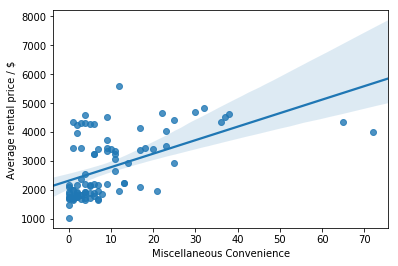

In [39]:
sns.regplot(x = 'Miscellaneous Convenience', y = 'Average rental price / $', data = df_rental_summary)
pearson_coef, p_value = stats.pearsonr(df_rental_summary[['Miscellaneous Convenience']], df_rental_summary[['Average rental price / $']])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  
r_value = stats.linregress(df_rental_summary['Miscellaneous Convenience'].to_numpy(), df_rental_summary['Average rental price / $'].to_numpy()).rvalue
print('R-sqaured is ', r_value**2)

The Pearson Correlation Coefficient is [0.52409953]  with a P-value of P = [8.24767423e-08]
R-sqaured is  0.2746803182207788


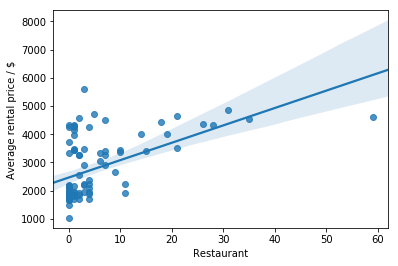

In [40]:
sns.regplot(x = 'Restaurant', y = 'Average rental price / $', data = df_rental_summary)
pearson_coef, p_value = stats.pearsonr(df_rental_summary[['Restaurant']], df_rental_summary[['Average rental price / $']])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  
r_value = stats.linregress(df_rental_summary['Restaurant'].to_numpy(), df_rental_summary['Average rental price / $'].to_numpy()).rvalue
print('R-sqaured is ', r_value**2)

The Pearson Correlation Coefficient is [0.39297655]  with a P-value of P = [0.00010668]
R-sqaured is  0.15443056737347743


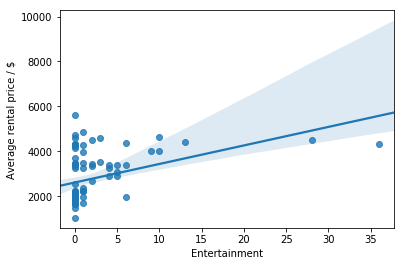

In [41]:
sns.regplot(x = 'Entertainment', y = 'Average rental price / $', data = df_rental_summary)
pearson_coef, p_value = stats.pearsonr(df_rental_summary[['Entertainment']], df_rental_summary[['Average rental price / $']])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 
r_value = stats.linregress(df_rental_summary['Entertainment'].to_numpy(), df_rental_summary['Average rental price / $'].to_numpy()).rvalue
print('R-sqaured is ', r_value**2)

<b>The Miscellaneous convenience venues and the Restaurant venues have relatively strong positive correlation with the rental prices according the corresponding regression plots and statistical evaluation.

<b>Use these three venue groups as variable to search for functions to describe their relationship with the rental prices.

<b>Multiple linear regression

In [42]:
Z = df_rental_summary[['Restaurant', 'Entertainment', 'Miscellaneous Convenience']]
lm = LinearRegression()
lm.fit(Z , df_rental_summary['Average rental price / $'])
yMLR = lm.predict(Z)

In [48]:
lm.intercept_

2333.948291067274

In [47]:
lm.coef_

array([29.57837235, 12.27090557, 27.3654195 ])

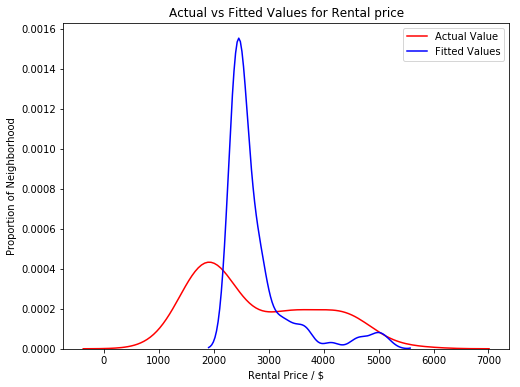

In [44]:
plt.figure(figsize=(8, 6))
ax1 = sns.distplot(df_rental_summary['Average rental price / $'], hist=False, color="r", label="Actual Value")
sns.distplot(yMLR, hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.title('Actual vs Fitted Values for Rental price')
plt.xlabel('Rental Price / $')
plt.ylabel('Proportion of Neighborhood')
plt.show()
plt.close()

In [46]:
print('The R-square is: ', lm.score(Z, df_rental_summary['Average rental price / $']))

The R-square is:  0.3243198738641


<b>Multiple linear regression does not give good prediction according to the above graph.

<b>Polynomial regression

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [50]:
Input=[('scale',StandardScaler()),
       ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(Z, df_rental_summary['Average rental price / $'])
yPF = pipe.predict(Z)

/Users/Weijing/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Weijing/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/Weijing/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


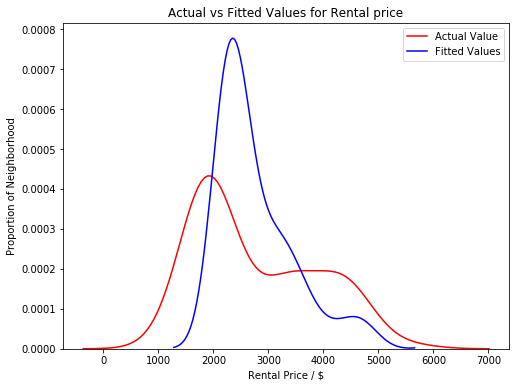

In [52]:
plt.figure(figsize=(8, 6))
ax1 = sns.distplot(df_rental_summary['Average rental price / $'], hist=False, color="r", label="Actual Value")
sns.distplot(yPF, hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.title('Actual vs Fitted Values for Rental price')
plt.xlabel('Rental Price / $')
plt.ylabel('Proportion of Neighborhood')
plt.show()
plt.close()

In [51]:
print('The R-square is: ', r2_score(df_rental_summary['Average rental price / $'], yPF))

The R-square is:  0.4024440445360751


<b>Multiple polynomial fit improves the fitting resulting, but the enhancement is limited.

<b>Use the three venue groups as the features to cluster the neighborhoods.

In [52]:
kclusters = 3
df_clustering = df_rental_summary[['Restaurant', 'Entertainment', 'Miscellaneous Convenience']]
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 1], dtype=int32)

In [53]:
#df_rental_summary.drop('Cluster Label', 1, inplace = True)
df_rental_summary.insert(0, 'Cluster Label', kmeans.labels_)
df_rental_summary.head()

,Cluster Label,Borough,Neighborhood,Average rental price / $,Latitude,Longitude,Restaurant,Entertainment,Miscellaneous Convenience
0,0,Manhattan,Marble Hill,1694,40.876551,-73.910660,0,0,7
1,0,Manhattan,Inwood,2225,40.867684,-73.921210,4,1,13
2,0,Manhattan,Washington Heights,2243,40.851903,-73.936900,3,0,13
3,0,Manhattan,East Harlem,3334,40.792249,-73.944182,6,2,11
4,0,Manhattan,Tudor City,3338,40.746917,-73.971219,0,0,9


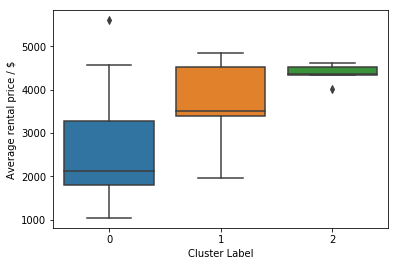

In [54]:
sns.boxplot(x="Cluster Label", y="Average rental price / $", data=df_rental_summary)

<b>The rental prices show some correlation with clustering when the number of cluster is 3. However, the overlap in the rental price is also significant, indicating the rental prices depend less on the the patterns of the venues in these neighborhoods.

In [55]:
df_rental_summary[df_rental_summary['Cluster Label'] == 0]

,Cluster Label,Borough,Neighborhood,Average rental price / $,Latitude,Longitude,Restaurant,Entertainment,Miscellaneous Convenience
0,0,Manhattan,Marble Hill,1694,40.876551,-73.910660,0,0,7
1,0,Manhattan,Inwood,2225,40.867684,-73.921210,4,1,13
2,0,Manhattan,Washington Heights,2243,40.851903,-73.936900,3,0,13
3,0,Manhattan,East Harlem,3334,40.792249,-73.944182,6,2,11
4,0,Manhattan,Tudor City,3338,40.746917,-73.971219,0,0,9
5,0,Manhattan,Roosevelt Island,3427,40.762160,-73.949168,1,0,10
6,0,Manhattan,Stuyvesant Town,3720,40.731000,-73.974052,0,0,9
7,0,Manhattan,Turtle Bay,3973,40.752042,-73.967708,1,1,2
10,0,Manhattan,Sutton Place,4135,40.760280,-73.963556,1,0,17
11,0,Manhattan,Civic Center,4241,40.715229,-74.005415,0,0,2


In [56]:
df_rental_summary[df_rental_summary['Cluster Label'] == 1]

,Cluster Label,Borough,Neighborhood,Average rental price / $,Latitude,Longitude,Restaurant,Entertainment,Miscellaneous Convenience
9,1,Manhattan,Murray Hill,4022,40.748303,-73.978332,14,10,23
19,1,Manhattan,Greenwich Village,4415,40.726933,-73.999914,18,13,25
24,1,Manhattan,Upper West Side,4654,40.787658,-73.977059,21,10,22
25,1,Manhattan,Lincoln Square,4706,40.773529,-73.985338,5,0,30
26,1,Manhattan,Little Italy,4845,40.719324,-73.997305,31,1,32
52,1,Brooklyn,Carroll Gardens,2916,40.680540,-73.994654,7,5,25
56,1,Brooklyn,Prospect Heights,3373,40.676822,-73.964859,10,5,17
58,1,Brooklyn,Fort Greene,3403,40.688527,-73.972906,15,6,20
60,1,Brooklyn,Brooklyn Heights,3456,40.695864,-73.993782,10,2,18
62,1,Brooklyn,Park Slope,3513,40.672321,-73.977050,21,3,23


In [57]:
df_rental_summary[df_rental_summary['Cluster Label'] == 2]

,Cluster Label,Borough,Neighborhood,Average rental price / $,Latitude,Longitude,Restaurant,Entertainment,Miscellaneous Convenience
8,2,Manhattan,Financial District,4005,40.707107,-74.010665,19,9,72
17,2,Manhattan,East Village,4334,40.727847,-73.982226,28,36,36
18,2,Manhattan,Chelsea,4359,40.744035,-74.003116,26,6,65
21,2,Manhattan,West Village,4524,40.734434,-74.006180,35,28,37
23,2,Manhattan,Chinatown,4609,40.715618,-73.994279,59,3,38
